# Lab3.3 Training an emotion classifier using embeddings

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

## 1 Quick introduction to embeddings

Extracting features manually can get us a long way. In addition to lemma and part-of-speech, people have used other information: features of the previous words (on the left) or the next words (on the right), whether the current word starts with a capital, whether it is an abbreviation, etc.

A recent alternative way to create a 'semantic' representation of a word is by word embeddings: mapping words (or phrases) from the vocabulary to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with many dimensions per word to a continuous vector space with a much lower dimension. For this reason, they are called dense representations.

In linguistics, word embeddings were discussed in the research area of distributional semantics. The idea is to quantify and categorize semantic similarities between linguistic items based on their distributional properties in large samples of language data. The underlying notion is that "a word is characterized by the company it keeps" (Firth). Embeddings are however the weights in the hidden layer of a neural network that is trained to predict the contexts rather than representing the context in a vector directly.

### Reference:

For a nice explanation how word embedddings can improve classical bag-of-word approaches, check out this page:

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html


In this section, we will load pre-trained word embeddings called word2vec, created by Google. The embeddings have 300 dimensions.

First, please download the file from [Kaggle](https://www.kaggle.com/pkugoodspeed/nlpword2vecembeddingspretrained). Then, create a folder and unpack the word2vec file in that folder.

We will load the embedding model with the Gensim package that we used before.

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import gensim
import numpy as np

In [85]:
##### Change to path to the location of your local copy of the GoogleNews embeddings
##### It may take a  minute to load the model
path_to_model = '/Users/piek/Desktop/ONDERWIJS/data/word-embeddings/classical-models/GoogleNews-vectors-negative300.bin'
word_embedding_model = gensim.models.KeyedVectors.load_word2vec_format(path_to_model, binary=True)  


In case you computer cannot handle big models such as the Google news model, you can also download one of the smaller 'Glove' datasets. These are provided as text files and 'gensim' provides a function to convert and load them. Note that these models have less domensions than the Google model and you need to adapt the number of features in the code below.

In [12]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/Users/piek/Desktop/ONDERWIJS/data/word-embeddings/classical-models/glove.6B.50d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)
word_embedding_model = KeyedVectors.load_word2vec_format(tmp_file)


Instead of downloading the models to disk, 'gensim' also provides a downloader API to load the model from the web when needed. In the next cell, we use this API to download a word embeddding model trained on tweets. Note that these are GloVe embeddings built using Tweets as the name suggests. These vectors are based on 2B tweets, 27B tokens, 1.2M vocab, uncased. The original source can be found here: https://nlp.stanford.edu/projects/glove/. The 25 in the model name refers to the dimensionality of the vectors.

In [2]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
# download the model and return as object ready for use
word_embedding_model = api.load("glove-twitter-25")

Let's check if the model works.

In [3]:
word1='cat'
word2='dog'
word1_vector=np.array(word_embedding_model[word1]).reshape(1, -1)
word2_vector=np.array(word_embedding_model[word2]).reshape(1, -1)
print(cosine_similarity(word1_vector, word2_vector))

[[0.9590821]]


## 2. Loading the emotion data

In [5]:
import pandas as pd
filepath = './data/MELD/train_sent_emo.csv'
df = pd.read_csv(filepath)

# 3. Preparing the training and test data

The following import are needed again:

In [24]:
import sklearn
import numpy
import nltk
from nltk.corpus import stopwords

In the previous notebook, we used CountVectorizer to obtain the full vocabulary of the data set and generate vectors for the one-hot-endcoing of each word. In these vectors, each slot represents a word and a value '1' indicates that the word was present in the utterance and a '0' means absence. This results is large and sparse vector representations for each utterance. We have also seen that we can weight the relevance of a word using the 'TF.IDF' function. This still results in large and sparse vectors but weights are more subtle. The down side is sparseness, lack of generalisation and lack robustness. 

In the following, we are going to represent the utterances by an embedding representation. In fact, we take the word embedding of each token in the utterance and add these together, after which we take the average. All the embeddings have the same number of dimensions in the same order. So if two tokens have a high weight for one dimension then their co-uccurrence in an utterance will enforce that weight. Note that by adding and taking the average, we normalize for the length of the utterance and the order of the tokens is not relevant.

We are going to define two customized function using 'def' to create an embedding representation for each utterance. These functions are taken from: https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec

The first function, called 'featureVecMethod', takes the words of the utterance and the embedding model as parameters. The num_features parameter determines the size of the vector. 

In [51]:
unknown_words =[]
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    # This create a numpy array with the length of the num_features set to zero values
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    #Allows for quicker lookup if the words exist
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
        else:
            word = word.lower()
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,model[word])
            else:
                #we keep track of the unknown words to see how well our model fits the data
                unknown_words.append(word)
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

The next function just deals with all the data and creates the list of input vectors. This function calls the previous function

In [58]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(texts, model, num_features):
    counter = 0
    textFeatureVecs = np.zeros((len(texts),num_features),dtype="float32")
    for text in texts:
        # Printing a status message every 1000th text
        if counter%200 == 0:
            print("Review %d of %d"%(counter,len(texts)))
            
        textFeatureVecs[counter] = featureVecMethod(text, model, num_features)
        counter = counter+1
    return textFeatureVecs

Now back to our input data. We iterate over the Pandas frame in the same way as before but now we extract for each utterance the embedding representation.

In [100]:
# Calculating average feature vector for training set
### This is the number of dimensions in the word2vec model used. 
###The Google news model has 300 dimensions but if you use a Glove model you may have to adapt this accordinlgy

num_features = 300
training_vectors = []
training_labels = []
for index, utterance in enumerate(df['Utterance']):
    ### Running this for all data requires a lot of memory and takes about an hour.
    ### For teaching purposes, it makes sense to limit the data
    ### we limit the data to the first 1000 utterances
    ### if index==2000:
    ##    break
    training_vectors.append(nltk.tokenize.word_tokenize(utterance))
    training_labels.append(df['Emotion'].iloc[index])

trainDataVecs = getAvgFeatureVecs(training_vectors, word_embedding_model, num_features)
#### Due to the averaging, there could be infinitive values or NaN values. The next numpy function turns these value to "0" scores
trainDataVecs = np.nan_to_num(trainDataVecs)  

Review 0 of 9989


/Users/piek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


Review 200 of 9989
Review 400 of 9989
Review 600 of 9989
Review 800 of 9989
Review 1000 of 9989
Review 1200 of 9989
Review 1400 of 9989
Review 1600 of 9989
Review 1800 of 9989
Review 2000 of 9989
Review 2200 of 9989
Review 2400 of 9989
Review 2600 of 9989
Review 2800 of 9989
Review 3000 of 9989
Review 3200 of 9989
Review 3400 of 9989
Review 3600 of 9989
Review 3800 of 9989
Review 4000 of 9989
Review 4200 of 9989
Review 4400 of 9989
Review 4600 of 9989
Review 4800 of 9989
Review 5000 of 9989
Review 5200 of 9989
Review 5400 of 9989
Review 5600 of 9989
Review 5800 of 9989
Review 6000 of 9989
Review 6200 of 9989
Review 6400 of 9989
Review 6600 of 9989
Review 6800 of 9989
Review 7000 of 9989
Review 7200 of 9989
Review 7400 of 9989
Review 7600 of 9989
Review 7800 of 9989
Review 8000 of 9989
Review 8200 of 9989
Review 8400 of 9989
Review 8600 of 9989
Review 8800 of 9989
Review 9000 of 9989
Review 9200 of 9989
Review 9400 of 9989
Review 9600 of 9989
Review 9800 of 9989


Training the classifier may take a while. If you laptop cannot handle it, reduce the number of training data. Alternatively, you can use a smaller word2vec embeddings model. Here is a website with many ready to use models: http://vectors.nlpl.eu/repository/

You can either choose a model with a smaller vocabulary or with less dimensions. Whatever you choose, make sure you can load the model using the 'gensim' package. If you choose a model with less than 300 dimensions (e.g. 100 or 200), you also need to adapt the value for *num_features* accordingly = 300.

Let's inspect our training data a bit more. Depending on the break set for loading the training data, you will have a list of vectors withaccording length:

In [101]:
len(trainDataVecs)

9989

We can inspect the first element in the list:

In [102]:
print (trainDataVecs[0])

[ 0.07684708 -0.00589172  0.02087148  0.11798096 -0.04772949 -0.01715597
  0.02614339 -0.11579386  0.04850769  0.02785238 -0.03663826 -0.15763347
  0.02907181 -0.04206848 -0.10516357  0.00802612  0.0634257   0.03068542
  0.02021281 -0.05789185 -0.02016195  0.07416788  0.00852458 -0.00821877
  0.02248383 -0.01269786 -0.09710693  0.06789144  0.04491933  0.00450643
  0.00296529 -0.02999941 -0.04688009  0.01657613  0.07224242  0.01447296
  0.01045227 -0.02872213 -0.00119019  0.04607487  0.03552373 -0.04069011
  0.12017822 -0.00052039  0.05973307  0.0153656  -0.04728699  0.00604757
  0.01460775  0.0330251   0.04984538 -0.00252279  0.0315094  -0.03960673
 -0.01564662  0.11189779 -0.06500244 -0.00463867  0.02598063 -0.07684326
 -0.07438151  0.07448324 -0.07838949 -0.05582174  0.04042562  0.00209427
 -0.02225749  0.1107076  -0.003479    0.10576376  0.04252116 -0.03523
  0.07209269 -0.01674398 -0.08915202 -0.06871542  0.09671656  0.08358002
  0.05035909  0.12894695  0.09892273 -0.10040792  0.13

It is simply a list with 300 digits, each representing the averaged weight of the tokens or words that made up the utterance.. We can checks the length, which should be '300'

In [103]:
len(trainDataVecs[0])

300

This is true for each utterance, each having a unique set of weights. These weights represent the meaning of the utterance for a machine, which can use a similarity function such as cosine similairty to measure the degree of equivalence across these representations. When we inspects the next utterance, we see it is represented in a simlar way. The first weight is pretty similar but the second is more different, etc.

In [104]:
print(trainDataVecs[1])
print(len(trainDataVecs[1]))

[ 0.07052612  0.0262207   0.0149292   0.18180808 -0.15498047  0.01761627
  0.05682678 -0.08862305  0.00136108  0.06259765 -0.05141602 -0.13657837
 -0.07398681  0.03161621 -0.15654297  0.06861572  0.14526367  0.07695313
  0.08779297 -0.03227539 -0.02880859  0.01967773  0.0975586   0.04521484
  0.0101181   0.03612518 -0.07314453  0.0230957   0.05827179 -0.05800781
 -0.03256836  0.06379394 -0.10352783  0.04261475 -0.07224121 -0.00427246
  0.00888672  0.00800781 -0.04592285  0.05229492  0.00623779 -0.12514648
  0.15625    -0.00369873  0.03867187  0.05134583 -0.02894287 -0.00957031
  0.18562011 -0.04592285 -0.0126709   0.13046876  0.05802002  0.01310196
  0.0359375   0.03659668 -0.02363281 -0.05742187  0.11518554  0.04990234
 -0.0708252   0.05776367 -0.07077637 -0.06506348  0.01157227  0.00436401
  0.05406494  0.02436524 -0.04849853  0.03852539  0.14457397  0.07898559
  0.07023926  0.10292969 -0.2105957  -0.11464844  0.18388672  0.2040039
  0.08886719  0.08862305 -0.07120361 -0.13330078  0.

For training, we use the same labels as before:

In [105]:
print(training_labels[0], training_labels[1])

neutral neutral


So now we have a numeric representation of each text, based on the embeddings of the words. We feed this to a classifier in the same way as we did in the previous notebooks with the Countvectorizer output.

Before we can train the classifier, we stil need to convert the labels to numeric values as we did before.

Before we do that, it may be good to check which words are not in the embedding model and therefore do not contribute to the representation of the utterance. In the above function, we kept track of the unknown words. Now we can inspect this list.

In [106]:
from collections import Counter
unknown_words_count = Counter(unknown_words)
print('Number of unknown words',len(unknown_words_count))
print('Unknown words counts')
print(unknown_words_count)

Number of unknown words 1115
Unknown words counts
Counter({',': 8625, '.': 7772, '!': 5094, '?': 3461, 'to': 1927, 'a': 1843, 'i\x92m': 1160, 'and': 1122, 'don\x92t': 894, "'s": 799, 'it\x92s': 776, 'of': 765, '...': 722, 'that\x92s': 598, 'you\x92re': 536, 'y\x92know': 376, 'can\x92t': 318, 'we\x92re': 228, 'i\x92ll': 212, "y'know": 192, 'didn\x92t': 182, 'he\x92s': 178, 'i\x92ve': 172, 'let\x92s': 132, 'she\x92s': 132, 'there\x92s': 132, 'what\x92s': 118, '``': 105, "''": 100, 'they\x92re': 98, '..': 98, 'i-i': 93, 'doesn\x92t': 88, 'pheebs': 87, 'i\x92d': 86, '\x91cause': 78, "'": 73, 'we\x92ll': 72, 'wouldn\x92t': 64, '’': 62, 'and-and': 60, 'you\x92ve': 58, 'you\x92ll': 56, 'no-no-no': 50, 'won\x92t': 50, 'haven\x92t': 48, '\x91em': 48, 'wasn\x92t': 46, 'couldn\x92t': 46, 'who\x92s': 46, '....': 43, ':': 40, 'i\x92m-i\x92m': 38, 'isn\x92t': 38, 'no-no': 35, 'uh-huh': 34, 'shouldn\x92t': 30, 'here\x92s': 30, 'you\x92d': 30, 'doin\x92': 28, 'hey-hey': 28, 'no-no-no-no': 26, 'we-we':

In [107]:
from sklearn import preprocessing
# first we instantiate a label encode
le = preprocessing.LabelEncoder()
# we fee this encoder with the complete list of labels from our data
le.fit(training_labels)
print(list(le.classes_))
training_classes = le.transform(training_labels)
print(list(training_classes[0:20]))

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
[4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 6, 4, 6, 5, 6, 2, 4, 4]


The next steps are the same as for the previous notebook, except that we pass the embedding representations of the training data.

In [108]:
# Split data into training and test sets
# from sklearn.cross_validation import train_test_split  # deprecated in 0.18
from sklearn.model_selection import train_test_split

### we again use a aplit of 80% train and 20% test
docs_train, docs_test, y_train, y_test = train_test_split(
    trainDataVecs, # the tf-idf model
    training_classes, # the category values for each utterance represented as numeric values
    test_size = 0.20 # we use 80% for training and 20% for development
    ) 


In [109]:
print(docs_train[0:5])

[[ 5.9379578e-02 -2.3159504e-02  1.6125488e-01 ...  1.6021729e-02
   3.3599854e-02 -2.5695801e-02]
 [-9.8876953e-03  3.0395508e-02  6.8725586e-02 ... -5.9371948e-02
  -1.2207031e-04  9.5214844e-03]
 [ 7.1940102e-02  1.3651530e-02  8.8704430e-02 ... -1.0042318e-01
   5.5867512e-02 -4.4677734e-02]
 [ 6.7871094e-02  1.9531250e-01  1.2060547e-01 ... -2.0800781e-01
  -4.5166016e-02 -1.3281250e-01]
 [ 3.3335369e-02  5.4239910e-02  4.6775818e-02 ... -3.7935894e-02
  -4.1236877e-02 -6.9905601e-02]]


## 4. Training and applying the model

In [110]:
from sklearn import svm

svm_linear_clf = svm.LinearSVC()
svm_linear_clf.fit(docs_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [111]:
# Predicting the Test set results, find macro recall
y_pred_svm = svm_linear_clf.predict(docs_test)

## 5. Generating the test report

In [112]:
from sklearn.metrics import classification_report

report = classification_report(y_test,y_pred_svm,digits = 7)
print(le.classes_)
print('SVM ----------------------------------------------------------------')
print(report)

['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
SVM ----------------------------------------------------------------
              precision    recall  f1-score   support

           0  0.4186047 0.0753138 0.1276596       239
           1  0.4000000 0.0526316 0.0930233        38
           2  0.0000000 0.0000000 0.0000000        54
           3  0.4344828 0.1826087 0.2571429       345
           4  0.5179012 0.8878307 0.6541910       945
           5  0.2666667 0.0575540 0.0946746       139
           6  0.5324675 0.3445378 0.4183673       238

    accuracy                      0.5065065      1998
   macro avg  0.3671604 0.2286395 0.2350084      1998
weighted avg  0.4596365 0.5065065 0.4272780      1998



Remember the results from the notebook where we trained a NaiveBayes and SVM classifiers with one-hot-encodings of the words? Take some time to compare the results and think about the differences.

We show here some screen dumps:


#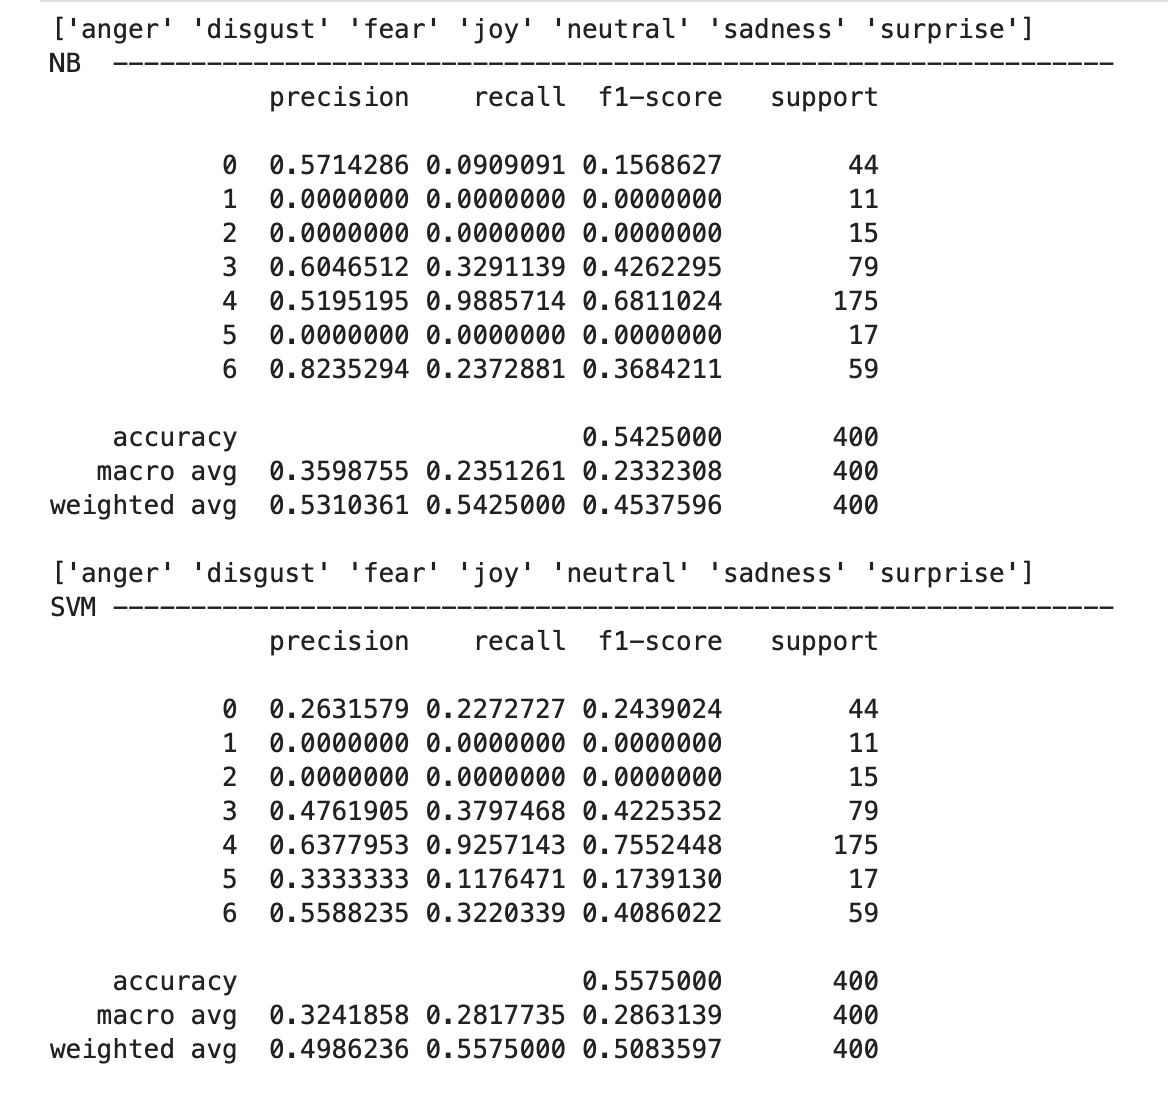

#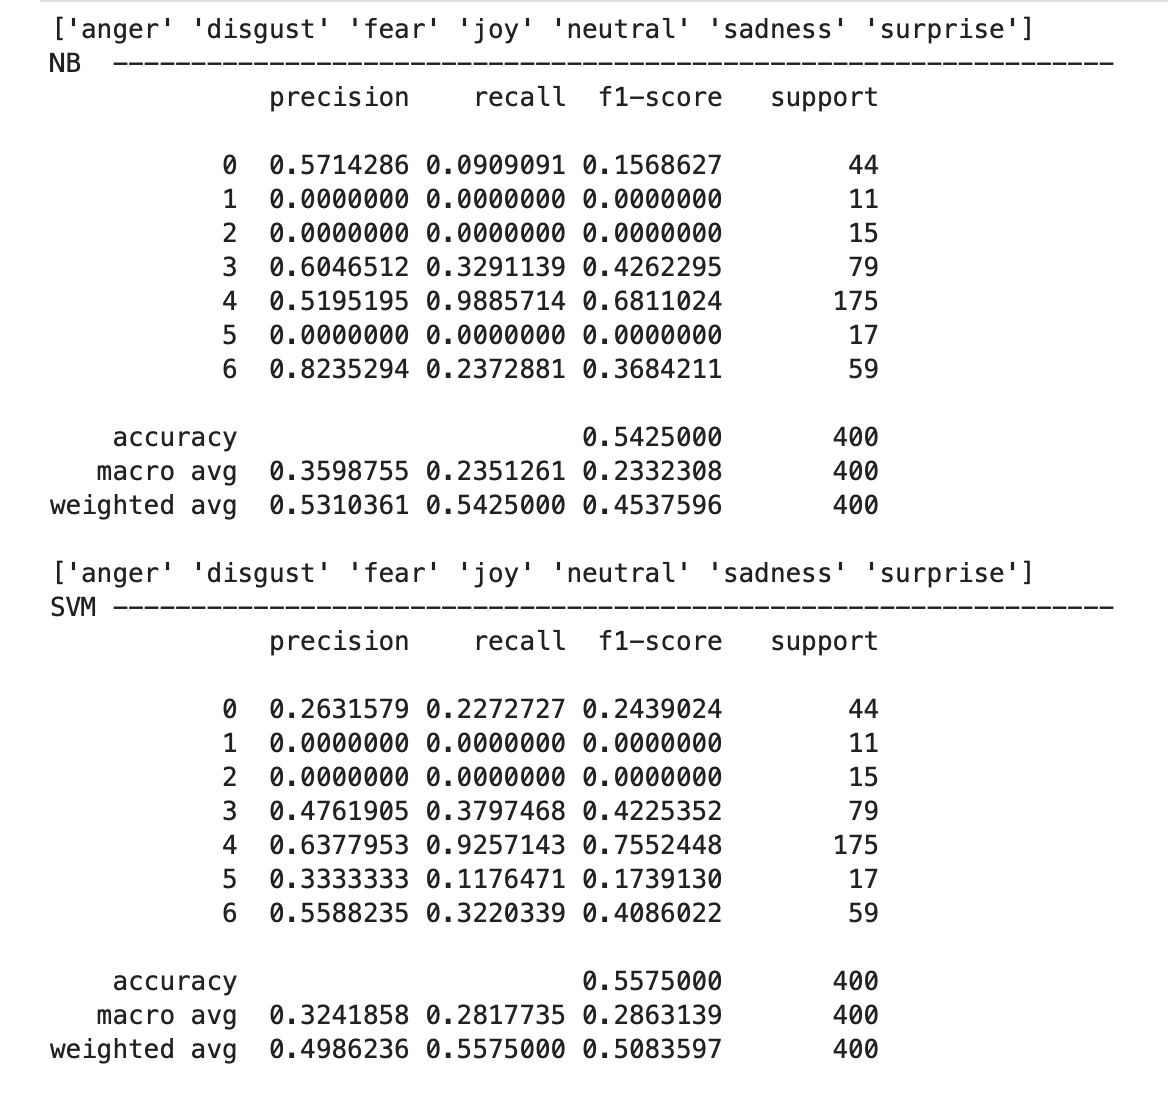


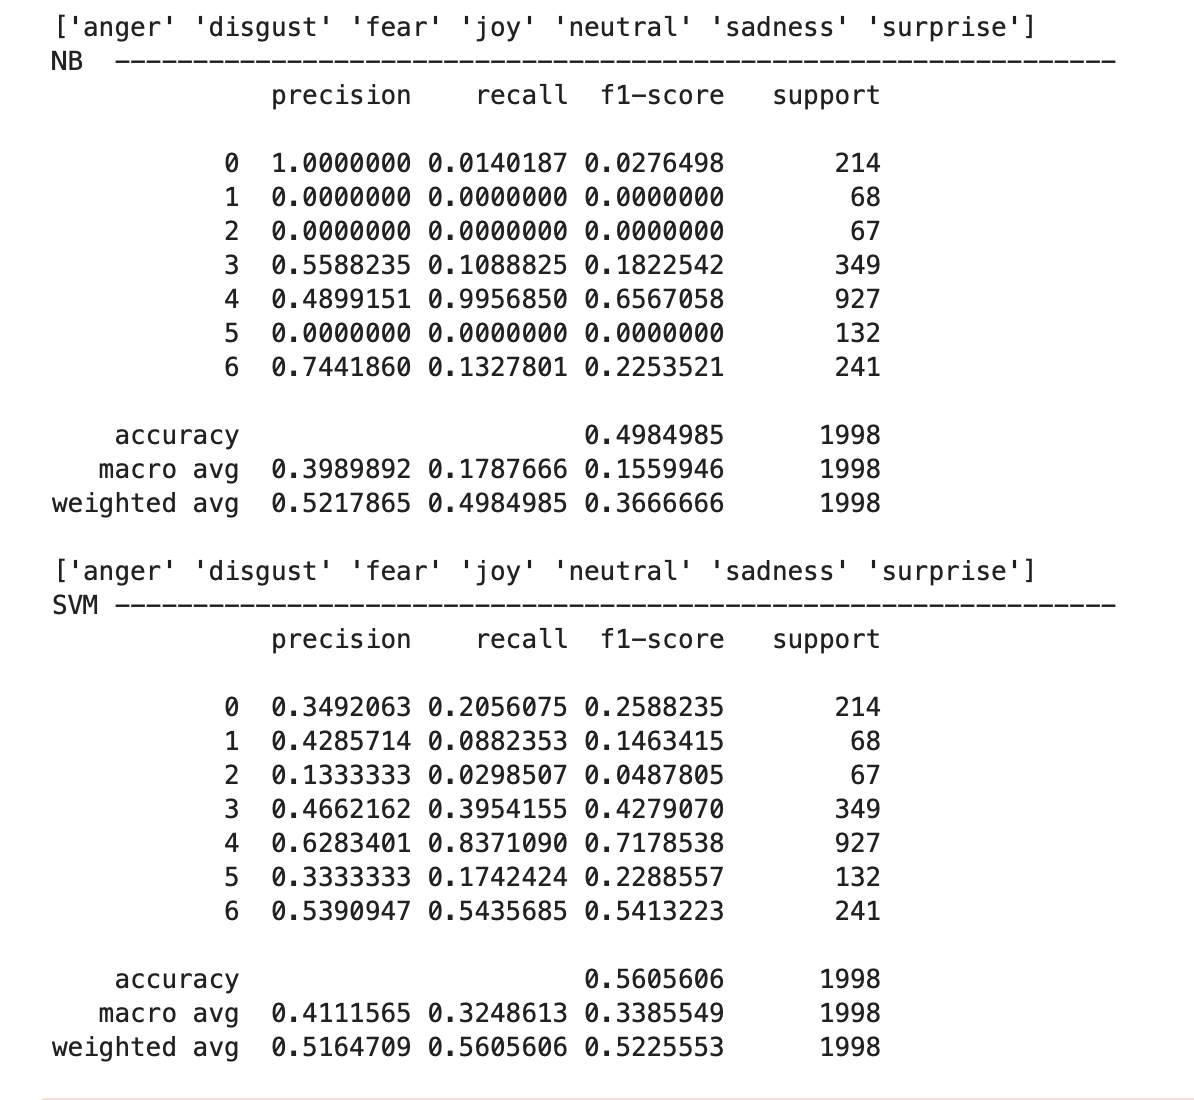

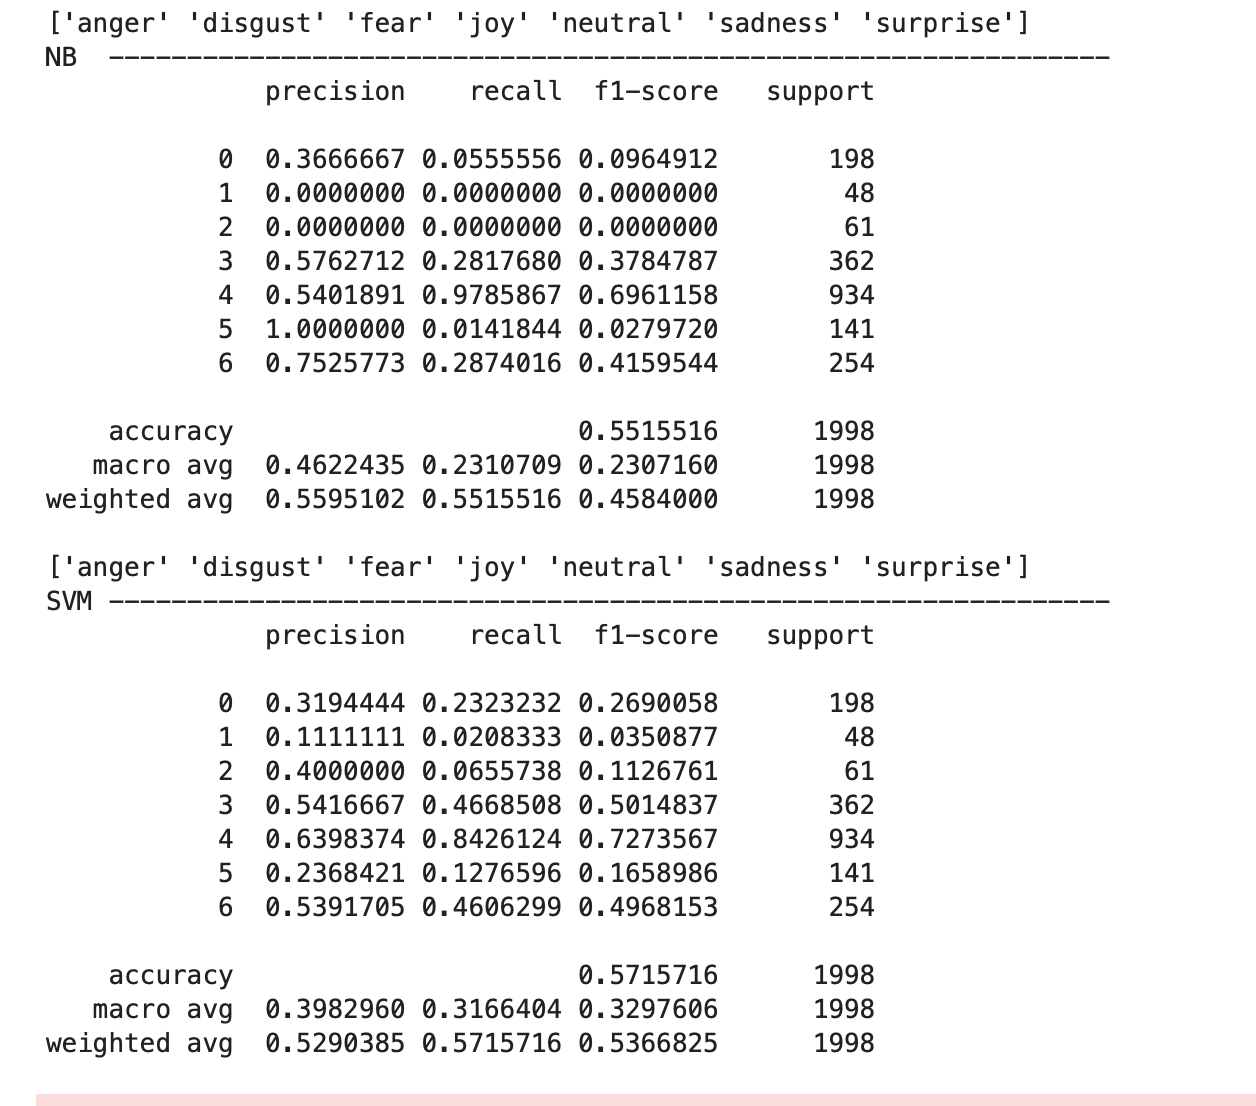

## 6. Applying the model to new data

We would like to apply the embedding based model to our own data but this works a bit different as we cannot simply use the 'transform' function to represent the utterances using the one-hot vector representation of the training vocabulary.

What we need to do is to create an embedding representation using the same function we used above and assume that our classifier finds sufficient similarity in the embeddings of our data with the correct training data.

We use the same set of utterances.

In [11]:
# some utterances
some_chat = ['That is sweet of you', 
               'You are so funny', 
               'Are you a man or a woman?', 
               'Chatbots make me sad and feel lonely.', 
               'Your are stupid and boring.', 
               'Two thumbs up', 
               'I fell asleep halfway through this conversation', 
               'Wow, I am really amazed.', 
               'You are amazing.']
len(some_chat)

9

In [113]:
num_features = 300
our_text_vectors = []
for utterance in some_chat:
    our_text_vectors.append(nltk.tokenize.word_tokenize(utterance))

ourDataVecs = getAvgFeatureVecs(our_text_vectors, word_embedding_model, num_features)
#### Due to the averaging, there could be infinitive values or NaN values. The next numpy function turns these value to "0" scores
ourDataVecs = np.nan_to_num(ourDataVecs)  

Review 0 of 9


/Users/piek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


In [114]:
# have classifier make a prediction
pred = svm_linear_clf.predict(ourDataVecs)
# print out results ()
for review, predicted_label in zip(some_chat, pred):
    
    print('%s => %s' % (review, 
                        le.classes_[predicted_label]))


That is sweet of you => neutral
You are so funny => joy
Are you a man or a woman? => surprise
Chatbots make me sad and feel lonely. => sadness
Your are stupid and boring. => anger
Two thumbs up => neutral
I fell asleep halfway through this conversation => neutral
Wow, I am really amazed. => surprise
You are amazing. => joy


Just as with the previous notebook, you can save the emotion classification model to disk and load the model some other time. Note that you need to load the same word2vec as well to represent any text input with vector representations that are compatible.

# End of this notebook